In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator,QiskitRuntimeService
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import transpile

import qiskit
print(qiskit.__version__)

2.1.1


In [2]:
n=3
iterations =  int((np.pi*np.sqrt(np.power(2,n)))//4)

print(iterations)

2


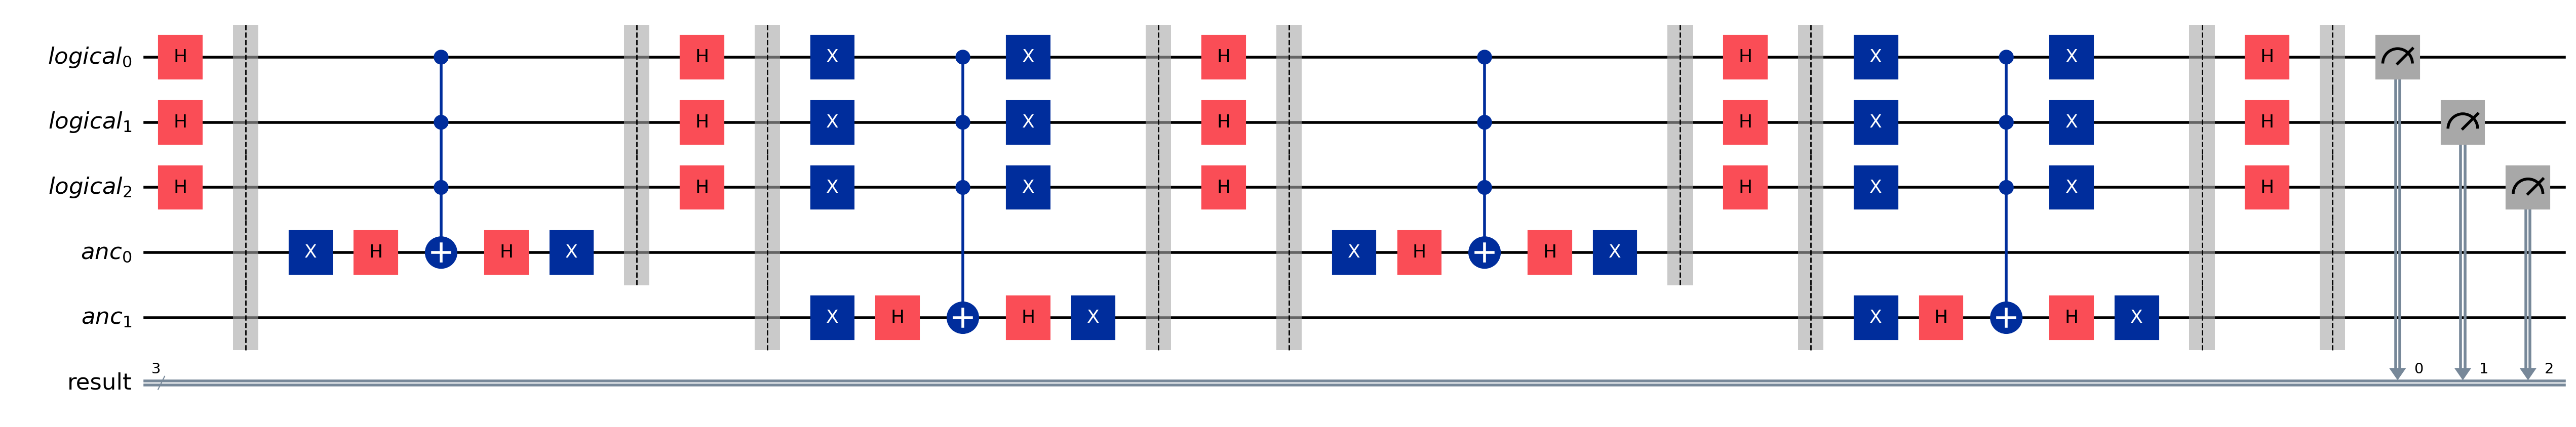

In [3]:

groverQ= QuantumRegister(n,name='logical')
groverCbit= ClassicalRegister(n,name='result')

ancilla= QuantumRegister(2,name='anc')


qc= QuantumCircuit(groverQ,ancilla,groverCbit)

# Initialise to + state n qubits
qc.h(groverQ)
qc.barrier()
for i in range(iterations):
    # Applying G=H x Z0 x H x Zf  t times

    ## Mirror image step
    # Apply Zf gate= C^5X on |-> state ancilla[0] =>
    qc.x(ancilla[0])
    qc.h(ancilla[0])

    qc.mcx(groverQ,ancilla[0])
    # Reverse ancilla[0] to ground state
    qc.h(ancilla[0])
    qc.x(ancilla[0])
    qc.barrier(groverQ,ancilla[0])
    
    ### Diffuser Step

    # Apply H gates again
    qc.h(groverQ)
    qc.barrier()
    # Prepare ancilla |->
    qc.x(ancilla[1])
    qc.h(ancilla[1])
    # Apply Z0 GATE
    qc.x(groverQ)
    qc.mcx(groverQ,ancilla[1])
    qc.x(groverQ)
    # reverse ancilla[1] to ground state
    qc.h(ancilla[1])
    qc.x(ancilla[1])
    qc.barrier()
    # Apply H gates again
    qc.h(groverQ)
    qc.barrier()
    
qc.measure(groverQ,groverCbit)
qc.draw('mpl', scale=2.0,fold=-1)

In [5]:
transpiled_qc= transpile(qc)
service = QiskitRuntimeService(name="qiskit_adi")

# Get a backend

backend = AerSimulator()
#backend = service.least_busy(operational=True, simulator=False)
#backend= service.backend(name='ibm_torino')
print(f"We are using the {backend.name} quantum computer")

sampler = Sampler(mode=backend)

We are using the aer_simulator quantum computer


In [6]:
# Submit the circuit to Sampler
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
job = sampler.run(pm.run([transpiled_qc]),shots=1024)

# Get the results
results = job.result()[0].data

{'111': 977, '101': 6, '000': 5, '100': 6, '010': 7, '001': 6, '110': 9, '011': 8}


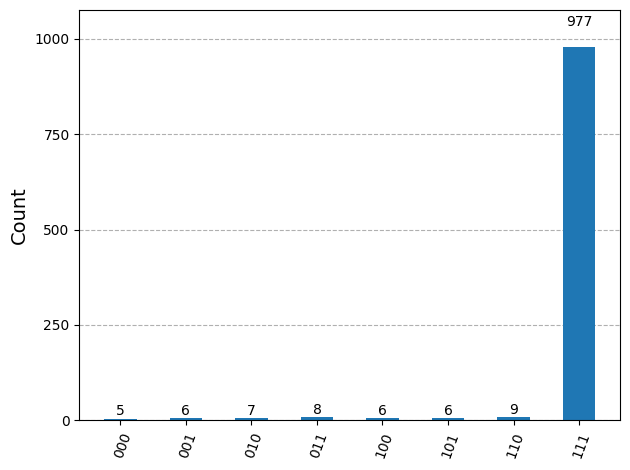

In [7]:
counts= results.result.get_counts()
print(counts)
plot_histogram(counts)